In [1]:
from src.OPFInterface import OPFClassifier
from functools import cmp_to_key
import pandas as pd
import numpy as np
from os import listdir
from src.utils import error, read_df, euclidean_distance_classify
from tqdm import tqdm
# plot
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

/mnt/c/Users/AndreFakhoury/Documents/GitHub/time-series-opf/venv/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/c/Users/AndreFakhoury/Documents/GitHub/time-series-opf/venv/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/c/Users/AndreFakhoury/Documents/GitHub/time-series-opf/venv/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/c/Users/AndreFakhoury/Documents/GitHub/time-series-opf/venv/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type 

In [2]:
def analyse(df_name):
    X, y, X_test, y_test, df_errors = read_df(df_name)
    opf = OPFClassifier('euclidean-distance')
    opf.fit(X, y)
    preds = opf.classify(X_test)
    ed_1nn = euclidean_distance_classify(X, y, X_test)
    return error(preds, y_test), error(ed_1nn, y_test)

In [3]:
def get_val(df_name):
    datasets_df = pd.read_csv('data/DataSummary.csv')
    df_a = datasets_df.loc[datasets_df['Name'] == df_name].iloc[:,[3,6]]
    return df_a.values[0][0] * df_a.values[0][1]

df_names = listdir('data/UCRArchive_2018')
df_values = [(get_val(df_name), df_name) for df_name in df_names]

df_values.sort()
df_names = [df_name for val, df_name in df_values]

In [4]:
opf_scores = []
for df_name in tqdm(df_names):
    opf_error, nn_error = analyse(df_name)
    opf_scores.append((df_name, opf_error, nn_error))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [21:30<00:00, 10.08s/it]


In [5]:
opf_scores.sort(key=lambda x: x[1]-x[2])
print(len(opf_scores))
df_best = [x for x in opf_scores if x[1]-1e-3 <= x[2]]
print(len(df_best))

128
55


Herring
ToeSegmentation1
ECG200
Ham
OSULeaf
GunPoint
Haptics
MiddlePhalanxTW
GesturePebbleZ2


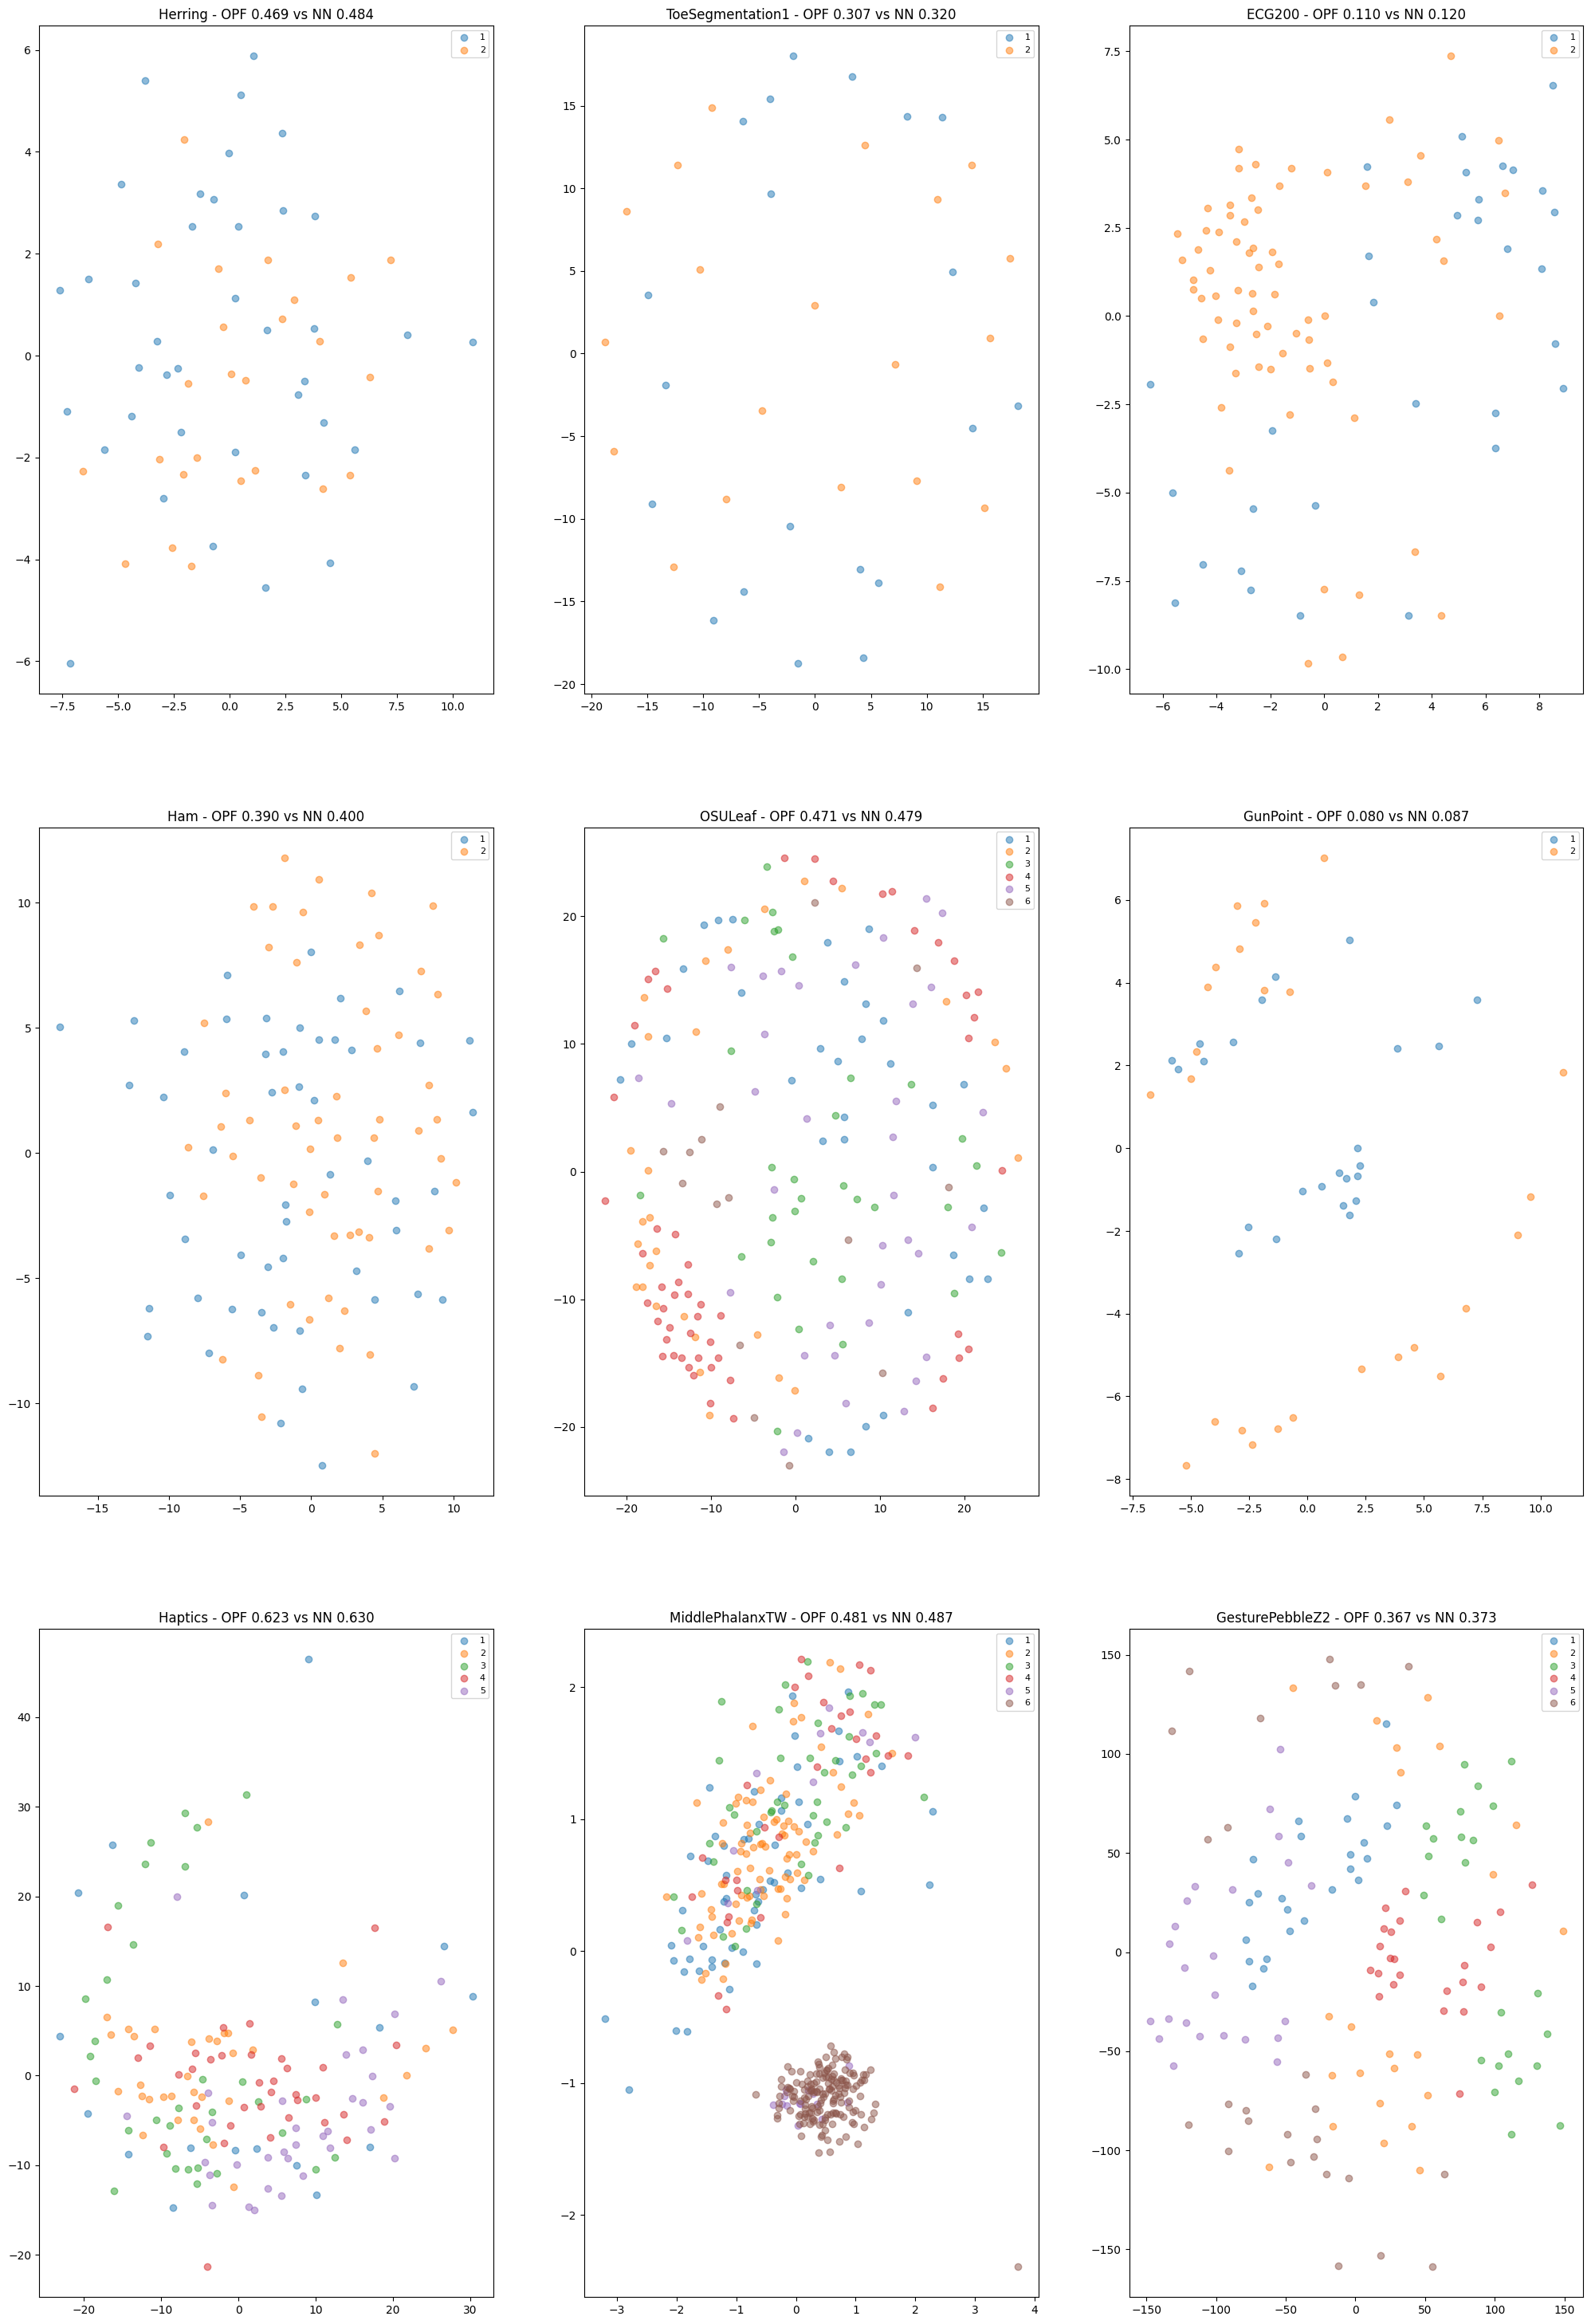

In [6]:
df_best_to_plot = df_best[:9]

fig, axes = plt.subplots((len(df_best_to_plot)+2)//3, 3, figsize=(25, 37))

def scatter_points(df_name, opf_error, nn_error, ax):
    X, y, X_test, y_test, df_errors = read_df(df_name)
    embedding = MDS(n_components=2)
    X_t = embedding.fit_transform(X)

    for cur_y in np.unique(y):
        ax.scatter(X_t[y==cur_y,0], X_t[y==cur_y,1], alpha=0.5)
    ax.legend(np.unique(y), fontsize=8, title_fontsize=8)
    ax.title.set_text("%s - OPF %.3f vs NN %.3f" % (df_name, opf_error, nn_error))
    
for idx, df_info in enumerate(df_best_to_plot):
    df_name, opf_error, nn_error = df_info
    print(df_name)
    scatter_points(df_name, opf_error, nn_error, axes.flatten()[idx])

plt.savefig('scatter.pdf')
plt.show()

In [11]:
EPS = 1e-3
maxd = 0
for name, opf_score, ed_score in opf_scores:
        X, y, X_test, y_test, df_errors = read_df(name)
        maxd = max(maxd, abs(df_errors["ED"] - ed_score))
        if abs(df_errors["ED"] - ed_score) > EPS:
            print(df_errors["ED"], ed_score, name)
print(maxd)

0.3291 0.37341772151898733 GesturePebbleZ2
0.875 0.7115384615384616 PigArtPressure
0.1774 0.16129032258064516 Fungi
0.1667 0.17333333333333334 BME
0.3373 0.0 InsectEPGSmallTrain
0.4 0.36 ShakeGestureWiimoteZ
0.1013 0.03164556962025317 GunPointAgeSpan
0.0253 0.006329113924050633 GunPointMaleVersusFemale
0.0476 0.0 GunPointOldVersusYoung
0.45 0.4125 DodgerLoopDay
0.0667 0.022222222222222223 PowerCons
0.3213 0.0 InsectEPGRegularTrain
0.6538 0.7 GestureMidAirD3
0.3361 0.31932773109243695 HouseTwenty
0.9423 0.9086538461538461 PigAirwayPressure
0.9183 0.8605769230769231 PigCVP
0.2383 0.10166666666666667 SemgHandGenderCh2
0.1525 0.05453054530545305 MelbournePedestrian
0.5956 0.2088888888888889 SemgHandSubjectCh2
0.0466 0.05539358600583091 Chinatown
0.4314 0.47 AllGestureWiimoteY
0.6311 0.4022222222222222 SemgHandMovementCh2
0.2883 0.2717857142857143 Crop
0.558 0.638121546961326 EOGVerticalSignal
0.0933 0.04666666666666667 SmoothSubspace
0.5457 0.5442857142857143 AllGestureWiimoteZ
0.4231 0.50

In [ ]:
X, y, X_test, y_test, df_errors = read_df("WordSynonyms")
opf = OPFClassifier('dtw-distance')
opf.fit(X, y)
preds = opf.classify(X_test)
error(preds, y_test), df_errors